In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import flattop, hann
from numpy.fft import fft, fftshift, fftfreq
#plt.rcParams["figure.figsize"] = (14,5)

In [2]:
filename = "wavegen400hz.csv"

# read the first lines which contain the acqusiotion parameters
try:
    fp = open(filename, 'r')
    line = fp.readline()
    line = fp.readline()
    line = fp.readline()
    sampleLength = int(line[(line.index(":")+1):])
    line = fp.readline()
    line = fp.readline()
    timeStep = int(line[(line.index(":")+1):-3])
    if (line[-3:-2] == 'u'):
        timeStep *= 1e-6
    else:
        timeStep *= 1e-9
finally:
    fp.close()

#samplingRate = 500 #kSa/s

data = np.loadtxt(filename, delimiter=",", skiprows=10)

In [3]:
#sampleLength = 2**14  #32768
window = hann(sampleLength) #hann(sampleLength, sym=True) ## np.hanning(sampleLength)
sig =  window * data[:sampleLength,1]
sp = fft(sig, n=None)
freq = fftfreq(sampleLength, d = timeStep)
sp_Vrms = np.abs(sp) * 2.0 / window.sum()

amplitude = (sig.max() - sig.min()) / 2.0

mag = 20 * np.log10(sp_Vrms  /1.0) 
#mag = mag - mag.max()

In [4]:
# compute THD
nrHarmonics = 9
ind0 = sp_Vrms[:sampleLength//2].argmax()
base = 20*np.log10(sp_Vrms[ind0])
THDarray = []
Freqarray = []
THDarray.append([sp_Vrms[ind0], base])
Freqarray.append(freq[ind0])
dd = 10
for i in range (2, nrHarmonics + 1):
    harm = sp_Vrms[(ind0 * i - dd):(ind0 * i + dd)].max()
    Freqarray.append(freq[sp_Vrms[(ind0 * i - dd):(ind0 * i + dd)].argmax() + (ind0 * i - dd)])
    THDarray.append([harm, 20*np.log10(harm)])
    print(" H{}: {:.2f} dB".format(i, 20*np.log10(harm) - base))    
THDarray = np.array(THDarray)
THD = np.sqrt(np.power(THDarray[1:,0], 2).sum()) / THDarray[0,0] * 100
print ("THD:  {:.3f}%".format(THD))


 H2: -41.37 dB
 H3: -48.92 dB
 H4: -55.75 dB
 H5: -71.05 dB
 H6: -86.21 dB
 H7: -56.43 dB
 H8: -61.52 dB
 H9: -58.52 dB
THD:  0.964%


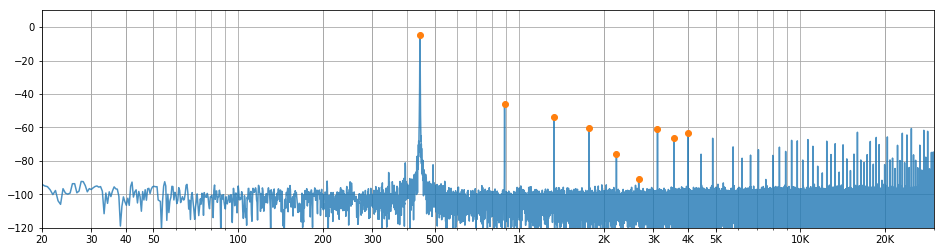

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
xscale = ax.set_xscale('log')
ax.set_xticks((10, 20, 30, 40, 50, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 50000, 100000))
xlim = ax.set_xlim(10, 100000)
ax.set_ylim(-120, 10)
ax.set_xlim(20, 30000)
import matplotlib.ticker

mkfunc = lambda x, pos: '%1.1fM' % (x * 1e-6) if x >= 1e6 else '%1.0fK' % (x * 1e-3) if x >= 1e3 else '%1.0f' % x
mkformatter = matplotlib.ticker.FuncFormatter(mkfunc)
ax.get_xaxis().set_major_formatter(mkformatter)
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.plot(freq[:sampleLength//2], mag[:sampleLength//2], alpha=0.8)
ax.plot(Freqarray, THDarray[:,1], 'o')
ax.grid(True, which="both", ls="-",color='0.65')

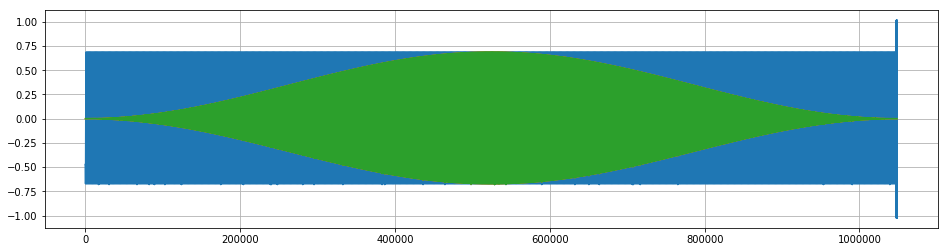

In [6]:
upto = sampleLength
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.plot(np.linspace(1,upto,upto),data[:upto,1], np.linspace(1,upto,upto),sig[:upto])
ax.plot(np.linspace(1,upto,upto),sig[:upto])
ax.grid(True)

(0, 1.3)

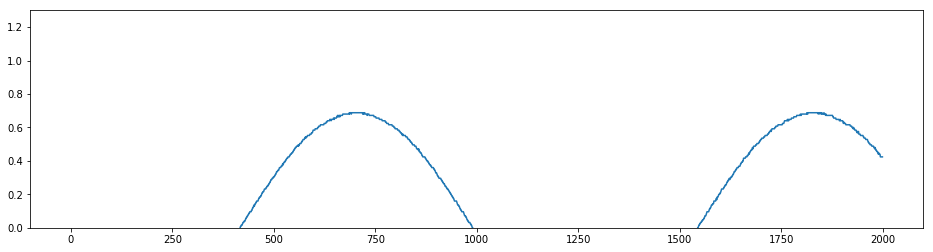

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.plot(data[:2000,1])
ax.set_ylim(0, 1.3)

In [ ]:
# interactive plot
import chart_studio.plotly as py
import plotly.express as px
import pandas as pd
df = pd.DataFrame({'Frequency (Hz)': freq[:sampleLength//2], 'Magnitude (dB)': mag[:sampleLength//2]})

In [ ]:
fig = px.line(df, x="Frequency (Hz)", y="Magnitude (dB)")
fig.update_layout(xaxis_type="log", width=770, height=400)
fig.show()

In [ ]:
sampleLength